## Redis数据结构

| 数据结构 | 小数据量 | 大数据量 | 用途 |
|---------|--------|--------|------|
| **String** | SDS（动态字符串）/ 整数优化（减少内存碎片化，提高操作效率） | SDS | 缓存、计数、分布式锁等 |
| **List** | Ziplist（压缩列表）+ 双向链表（紧凑存储，减少内存占用） | Quicklist（双向链表 + Ziplist，减少指针开销，提高访问速度） | 消息队列、时间轴、任务队列 |
| **Hash** | Ziplist（压缩列表）（节省内存，顺序存储） | Dict（哈希表，高效查询 `O(1)`） | 存储对象（用户信息、数据索引） |
| **Set** | Intset（有序数组，二分查找，节省内存） | Dict（哈希表，查询速度快 `O(1)`） | 去重、标签、交集/并集/差集计算 |
| **Zset** | Ziplist（压缩列表，节省内存，适用于少量元素） | Skiplist（跳表，范围查询高效 `O(logN)`）+ Dict（哈希表，快速定位元素） | 排行榜、定时任务、范围查询 |  

### 什么是小数据量
一般元素数量 <=512 (zset是128), 元素存储空间 <= 64字节

### String
没有长度限制，32位操作系统是4G，64位几乎无限制。  
预分配空间：扩容时分配稍大的空间。  
惰性空间释放：不会立即释放，而是预留空间。  


### Ziplist

```text
+------------+------------+------------+------------+--------+  
| zlbytes    | zltail     | zllen      | entry1 ... | zlend  |  
+------------+------------+------------+------------+--------+
```
#### Ziplist 优缺点对比

| **优点** | **缺点** |
|---------|---------|
| **节省内存**：连续存储，避免指针开销 | **插入、删除操作成本较高**：需要移动数据 |
| **数据紧凑**：适用于小数据量的存储 | **查询效率低**：`O(N)`，不适合大规模数据 |
| **支持整数压缩**：节省存储空间 | **不支持快速随机访问**：只能顺序遍历 |
| **适用于小型 Hash、List、Zset** | **超过阈值需转换**：会自动升级为 `Quicklist / Dict / Skiplist` |
| **尾部插入较快**（`zltail` 记录了尾部偏移量） | **中间插入可能触发内存重分配**，影响性能 |


### QuickList


```
Head <-> Ziplist1 <-> Ziplist2 <-> Ziplist3 <-> Tail
```
当string < 8kb, 一个string占用一个ziplist;  
当string > 8kb, 多个string放置在一个ziplist,直到接近8k。

#### Quicklist 优缺点对比

| **优点** | **缺点** |
|---------|---------|
| **减少指针开销**，相比双向链表节省内存 | **插入、删除中间节点** 仍可能触发 Ziplist 重分配 |
| **尾部操作高效**，适合 `push`、`pop` | **查询非头尾元素仍需遍历** |
| **支持数据压缩**，减少内存占用 | **压缩数据需要解压缩，可能影响性能** |
| **比单独的 Ziplist 更稳定**，不会因单个列表过大导致性能问题 | **大列表仍可能面临 CPU 和内存压力** |

### Hash
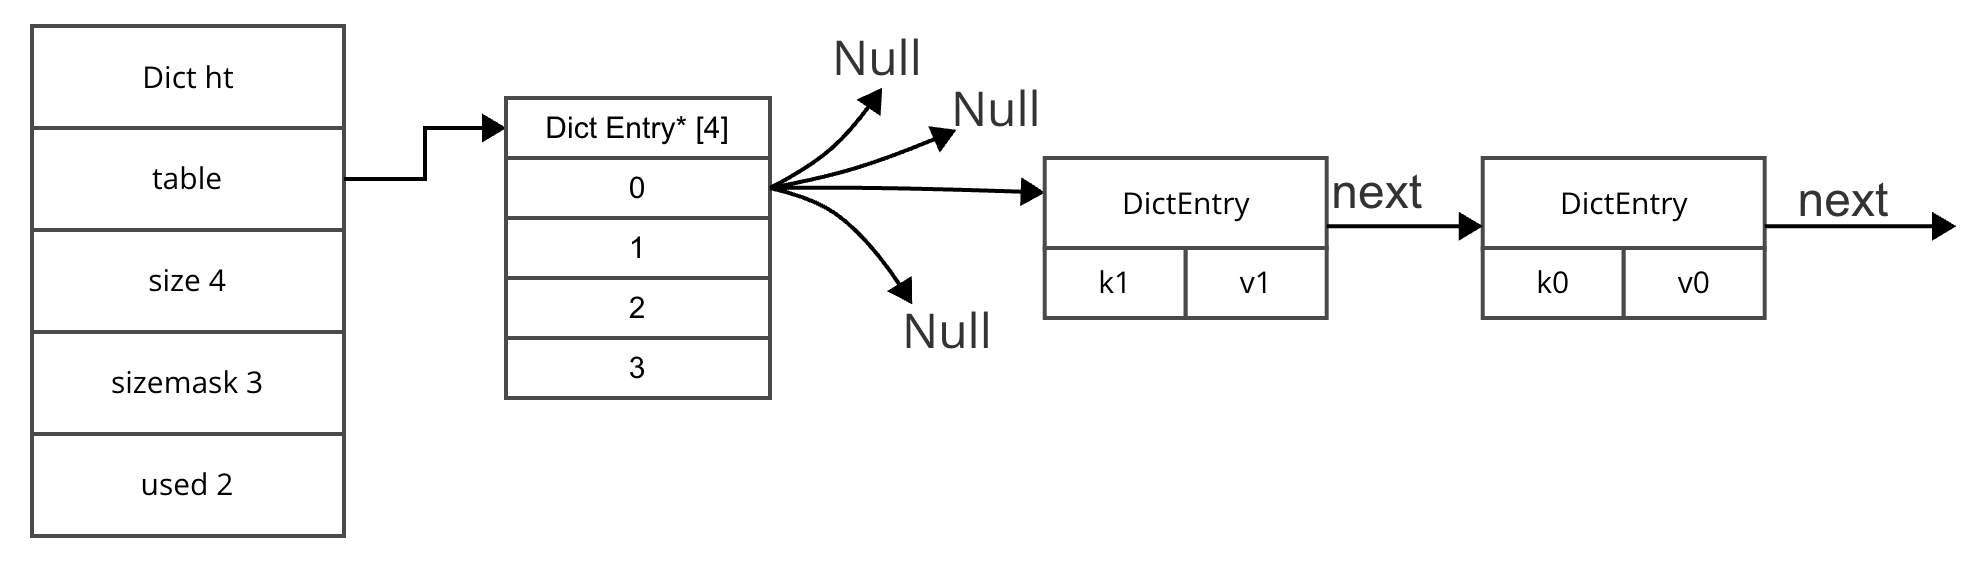

**如何解决键冲突**  
链地址法。


---
**Rehash**  
**什么时候需要rehash？**  
- 负载因子过高 (元素数量/桶数量， 默认是2)
- 扩展Hash表容量
  - Hash表大小增加，Redis将Hash表扩容1倍，以避免碰撞和查询效率降低

**如何rehash？**  
**扩容过程**  
- 创建一个新的hash表，容量翻倍
- 原键值对重新计算hash，并转移到新表
- 渐进的 不是立即完成

**渐进式rehash**  
- 为了避免因rehash造成的卡顿，rehash不会一次性完成
- redis每次对这个hash表的操作，都会进行一定数据的rehash迁移工作
- rehash的过程中， get等操作可能需要同时读新表和旧表




## 缓存问题

### 缓存穿透
问题： 大量不存在的key，绕过缓存， 命中db，造成db超负荷。  
解决方案： 布隆过滤器。


### 缓存雪崩
问题： 大量缓存突然失效，大量请求访问db重构缓存  
解决方案：
- 过期时间加一个随机数，使不在同一时间过期；
- 多级缓存
- 熔断和降级


### 缓存击穿
问题： 热key突然失效，打在db上  
解决方案：  
- 分布式锁 或 Semaphore 限制构建缓存的连接数
- 异步主动构建

### 缓存淘汰策略
1. 当空间未满时，expire key到期时 必定 被驱逐；
- 驱逐方式 （内置逻辑）：
  - 惰性驱逐，用到这个key,发现过期时驱逐
  - 定期删除(每100ms)，redis-server定期扫描过期并清除key（不保证驱逐所有过期key，有可能只是一部分）
2. 当空间已满时，没有设置expire的key，也会按照驱逐策略可能被驱逐；


**缓存驱逐策略**  
- LRU
- LFU (redis 4.0+)
- FIFO
- Random



```
maxmemory-policy allkeys-lru
```



| 策略 | 描述 | 适用场景 |
|:--|:--|:--|
| **`noeviction`** | ❌ 不驱逐，达到内存上限时写入操作会失败。 | 数据不能丢失的场景。 |
| **`allkeys-lru`** | 🔄 在所有键中，移除最久未使用的键。 | 需要尽可能保持**热点数据**的场景。 |
| **`volatile-lru`** | 🔄 在**带 `EXPIRE` 的键**中，移除最久未使用的键。 | 仅允许设置了 `EXPIRE` 的数据被驱逐。 |
| **`allkeys-random`** | 🎯 在所有键中，**随机移除**一个键。 | 适用于缓存数据无明显访问热点的场景。 |
| **`volatile-random`** | 🎯 在**带 `EXPIRE` 的键**中，**随机移除**一个键。 | 适合部分数据需要保证常驻内存。 |
| **`volatile-ttl`** | ⏳ 在**带 `EXPIRE` 的键**中，移除**存活时间最短**的键。 | 适合希望尽快淘汰即将过期的数据。 |
| **`allkeys-lfu`** | 🔥 在所有键中，移除**访问次数最少**的键。 | 适合访问频率不均衡，需保留热点数据的场景。 |
| **`volatile-lfu`** | 🔥 在**带 `EXPIRE` 的键**中，移除**访问次数最少**的键。 | 适用于仅缓存带 `EXPIRE` 数据，且保留热点数据。 |

### 缓存与db一致性

- 先更新数据库，再写缓存

❗ 缺点
	•	写操作完成后，若数据立即被访问，可能短暂读到旧缓存

- 先删除缓存，再更新数据库 (存在风险)。
可能构建脏数据

- 延迟双删
```
删除缓存
更新数据库
休眠一段时间（例如500ms， 需要大于查询db构建缓存的预期时间）
再次删除缓存
```
- 消息队列异步构建
- Cannal监控binlog构建




## 高并发实战

### 监控
监控指标：  
- CPU 使用率：确保不超过特定阈值（如 90%），以避免性能下降。
- 内存使用：跟踪数据库内存使用百分比和驱逐（evictions）情况，以有效管理内存。
- 网络流量：监控进出字节和数据包，以规划容量。
- 连接数：跟踪当前和新增连接，避免达到最大限制（如 65,000）。
- 复制状态：监控复制延迟和字节数，确保数据一致性。
- 延迟：使用慢日志和延迟指标识别并解决性能瓶颈。

Grafana，Promethues




### 缓存性能优化

**缓存预热**  
实现方式：使用定时任务或初始化脚本，将热点数据插入到redis

**热点key**  
使用nginx日志分析，流量监控工具（Grafana，Promethues）分析热点商品;  
在关键业务处添加**埋点**，统计关键指标。